In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from time import time

import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn
from torch import Tensor
from torch.nn import Transformer

chars = " ^$#%()+-./0123456789=@ABCDEFGHIKLMNOPRSTVXYZ[\\]abcdefgilmnoprstuy"
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
VOCAB_SIZE=len(chars)
PAD_IDX, BOS_IDX, EOS_IDX = 0,1,2

file = open("/home/arvid/data/USTPO_paper_5x/USTPO_5x_parsed.pickle",'rb')
data = pickle.load(file)

In [2]:
!nvidia-smi 

Thu Sep 23 14:44:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:1E:00.0 Off |                    0 |
| N/A   35C    P0    66W / 350W |   4066MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM3...  On   | 00000000:23:00.0 Off |                    0 |
| N/A   

In [3]:
DEVICE = torch.device('cuda:8' if torch.cuda.is_available() else 'cpu')
torch.torch.cuda.set_device(DEVICE)
print("Using device " + str(torch.torch.cuda.current_device()) + "/" + str(torch.cuda.device_count())
      +", name: " + str(torch.cuda.get_device_name(0)))
#device = torch.torch.cuda.current_device()

Using device 8/16, name: Tesla V100-SXM3-32GB


In [4]:
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader


class ReactionDataset(Dataset):

    def __init__(self, data, split, maxlen=160, rep=" ^$#%()+-./0123456789=@ABCDEFGHIKLMNOPRSTVXYZ[\\]abcdefgilmnoprstuy"):
        self.split = split
        self.data = data[self.split]
        self.maxlen = maxlen
        self.rep = rep
        self.char_to_ix = { ch:i for i,ch in enumerate(rep) }
        self.ix_to_char = { i:ch for i,ch in enumerate(rep) }
        # Add augmentation methods here later
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        rs_smiles = self.data[index]["rs"]
        ps_smiles = self.data[index]["ps"]
        
        
        rs_smiles = self.ix_to_char[BOS_IDX] + rs_smiles + self.ix_to_char[EOS_IDX] + (self.maxlen-len(rs_smiles))*" "
        ps_smiles = ps_smiles + (self.maxlen-len(ps_smiles)+2)*" "
        
        # Augment smiles here for train
        
        rs = torch.tensor([self.char_to_ix[char] for char in rs_smiles])
        ps = torch.tensor([self.char_to_ix[char] for char in ps_smiles])
        
        return {
            "rs": rs.to(dtype=torch.int64),
            "ps": ps.to(dtype=torch.int64)
            #'rs': F.one_hot(rs.to(dtype=torch.int64), num_classes=len(self.rep)),
            #'ps':  F.one_hot(ps.to(dtype=torch.int64), num_classes=len(self.rep))
        }

datasets = {}
dataloaders = {}
for split in ['train', 'eval']:
    datasets[split] = ReactionDataset(data=data,
                                   split=split)

    dataloaders[split] = DataLoader(datasets[split],
                                    batch_size=32,
                                    shuffle=(split != 'test'),
                                    num_workers=4,
                                    pin_memory=False)# Was True before.

In [5]:
#datasets["train"].__getitem__(10)["rs"]

next(iter(dataloaders["train"]))["rs"].shape

torch.Size([32, 162])

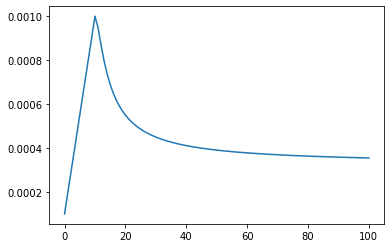

In [6]:
def generate_square_subsequent_mask(sz):
        mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX)
    tgt_padding_mask = (tgt == PAD_IDX)
    tgt_padding_mask[tgt == EOS_IDX] = True
    return src_mask, tgt_mask, src_padding_mask.permute(1,0), tgt_padding_mask.permute(1,0)

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 200):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        token_embedding = token_embedding
        return self.dropout((token_embedding + self.pos_embedding[:token_embedding.size(0), :]))
    
    
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                    N_ENCODERS: int=6,
                    N_DECODERS: int=6,
                    EMBEDDING_SIZE: int=512,
                    N_HEADS: int=8,
                    SRC_VOCAB_SIZE: int=VOCAB_SIZE,
                    TGT_VOCAB_SIZE: int=VOCAB_SIZE,
                    DIM_FF: int=512,
                    DROPOUT: float=0.0):
        super(Seq2SeqTransformer, self).__init__()
        
        
        self.transformer = Transformer(d_model=EMBEDDING_SIZE,
                                       nhead=N_HEADS,
                                       num_encoder_layers=N_ENCODERS,
                                       num_decoder_layers=N_DECODERS,
                                       dim_feedforward=DIM_FF,
                                       dropout=DROPOUT)
        
        self.generator = nn.Linear(EMBEDDING_SIZE, TGT_VOCAB_SIZE)
        
        self.src_tok_emb = TokenEmbedding(SRC_VOCAB_SIZE, EMBEDDING_SIZE)
        self.tgt_tok_emb = TokenEmbedding(TGT_VOCAB_SIZE, EMBEDDING_SIZE)
        
        self.positional_encoding = PositionalEncoding(
            EMBEDDING_SIZE, dropout=DROPOUT)

    def forward(self,
                src: Tensor,
                tgt: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)
    
def loss_fn(logits, tgt, tgt_padding_mask):
    #Shift outs and labels one step
    logits = logits[:-1,:,:].permute(1,0,2)
    one_hot_targets = F.one_hot(tgt, num_classes=VOCAB_SIZE)[1:,:,:].permute(1,0,2)
    weights = (~tgt_padding_mask[:,:-1]).long().unsqueeze(-1).tile([1,1,TGT_VOCAB_SIZE])
    
    criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
    #print(torch.sum(torch.mean(criterion(logits, one_hot_targets.float())*weights,axis=0),axis=(0,1)))
    loss = torch.sum(torch.mean(criterion(logits, one_hot_targets.float())*weights,axis=0),axis=(0,1))
    return loss


class CosineAnnealingWarmup():

    def __init__(self,
                 max_lr : float = 1e-3,
                 min_lr : float = 1e-4,
                 warmup_steps : int = 10,
                 base_lr: float = 1e-4,
                 gamma : float = 1,
                 last_epoch : int = 200
        ):
        
        self.base_max_lr = max_lr # first max learning rate
        self.max_lr = max_lr # max learning rate in the current cycle
        self.min_lr = min_lr # min learning rate
        self.warmup_steps = warmup_steps # warmup step size
        self.gamma = gamma # decrease rate of max learning rate by cycle
        self.base_lr = base_lr
        
        
    
    def get_lr(self, step):
        if step <= self.warmup_steps:
            return (self.max_lr - self.base_lr)*step / self.warmup_steps + self.base_lr
        elif step <= 100:
            return self.base_lr + (self.max_lr - self.base_lr) \
                    * (1+ math.cos(math.pi * (step - self.warmup_steps)/(step*1.5- self.warmup_steps))) / 2

cos = CosineAnnealingWarmup()
plt.plot([cos.get_lr(i) for i in range(200)])


In [7]:
def train_epoch(model, optimizer, split):
    if split == "train": model.train()
    else: model.eval()
        
    losses = 0
    for batch in tqdm(dataloaders[split], colour='ffffff'):
        src = batch["ps"].to(DEVICE).permute(1,0)
        tgt = batch["rs"].to(DEVICE).permute(1,0)


        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src=src, tgt=tgt)

        logits = chemFormer(src=src,tgt=tgt,src_mask=src_mask,
                            tgt_mask=tgt_mask,
                            src_padding_mask=src_padding_mask,
                            tgt_padding_mask=tgt_padding_mask,
                            memory_key_padding_mask=src_padding_mask)


        optimizer.zero_grad()

        loss = loss_fn(logits, tgt, tgt_padding_mask)
        if split=="train": loss.backward()

        optimizer.step()
        losses += loss.item()
        

    return losses / len(dataloaders[split])

In [8]:
def training_monitoring(model, optimizer, n_epochs, scheduler):
    
    model_dir = os.path.expanduser("~/models/transformers/")
    time()
    from datetime import datetime
    date_time = datetime.fromtimestamp(time())
    model_str = str(date_time.year)+"_"+str(date_time.month)+"_"+str(date_time.day)+"_"+str(date_time.hour)+"_"+str(date_time.minute)+"_"+str(date_time.second)
    os.mkdir(model_dir + model_str)
    os.mkdir(model_dir + model_str + "/logdir")
    print("tensorboard --logdir " + model_dir + model_str + "/logdir/ --port=6006")
    
    params_dict = {"N_ENCODERS": N_ENCODERS,
                   "N_DECODERS": N_DECODERS,
                   "EMBEDDING_SIZE": EMBEDDING_SIZE,
                   "N_HEADS": N_HEADS,
                   "SRC_VOCAB_SIZE": SRC_VOCAB_SIZE,
                   "TGT_VOCAB_SIZE": TGT_VOCAB_SIZE,
                   "DIM_FF": DIM_FF,
                   "DROPOUT": DROPOUT,
                   "BATCH_SIZE": BATCH_SIZE,
                   "MAX_SEQ_LEN": MAX_SEQ_LEN}
    
    with open(model_dir + model_str + '/params.pickle', 'wb') as handle:
        pickle.dump(params_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    best_loss = 999999999
    running_losses = {'train': [], 'eval': []}    
        
    # Loop
    writer = SummaryWriter(model_dir + model_str + "/logdir/")
    
    for epoch in range(n_epochs):
        
        lr = scheduler.get_lr(epoch)
        print(lr)
        for g in optimizer.param_groups:
            g['lr'] = lr
            
        losses = {}
        print()
        
        for split in ["train", "eval"]:
            print("Epoch " + str(epoch) + " " + split + " progression:")
            epoch_loss = train_epoch(model=model, optimizer=optimizer, split=split)
            
            losses[split] = epoch_loss
            running_losses[split].append(epoch_loss)
            writer.add_scalar('Loss/'+split, epoch_loss, epoch+1)
            
            if split == 'eval' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    torch.save(model.state_dict(),model_dir + model_str + "/weights")
            
        print("Epoch " + str(epoch) + " train/eval losses: " + str(losses["train"]) + " / " + str(losses["eval"]))

In [9]:
N_ENCODERS=6
N_DECODERS=6
EMBEDDING_SIZE=512
N_HEADS=8
SRC_VOCAB_SIZE,TGT_VOCAB_SIZE=VOCAB_SIZE,VOCAB_SIZE
DIM_FF=512
DROPOUT=0.1
BATCH_SIZE=32
MAX_SEQ_LEN=160

torch.manual_seed(0)

chemFormer = Seq2SeqTransformer(N_ENCODERS=N_ENCODERS,
                                N_DECODERS=N_DECODERS,
                                EMBEDDING_SIZE=EMBEDDING_SIZE,
                                N_HEADS=8,
                                SRC_VOCAB_SIZE=SRC_VOCAB_SIZE,
                                TGT_VOCAB_SIZE=TGT_VOCAB_SIZE,
                                DIM_FF=DIM_FF,
                                DROPOUT=DROPOUT).to(DEVICE)

optimizer = torch.optim.Adam(chemFormer.parameters(), lr=1e-5, betas=(0.9, 0.98), eps=1e-9)
scheduler = CosineAnnealingWarmup()


In [10]:
#training_monitoring(model=chemFormer, optimizer=optimizer, n_epochs=200, scheduler=scheduler)

In [11]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    if src_mask != None: src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        if next_word == EOS_IDX:
            break
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
    return ys[1:,:]

In [12]:
chemFormer.load_state_dict(torch.load("/home/arvid/models/transformers/2021-09-23-12:12:11/weights"))
chemFormer.transformer.dropout = 0.0
from rdkit import Chem
for i in range(300):
    batch = next(iter(dataloaders["eval"]))
    src = batch["ps"]
    tgt = batch["rs"]
    src=src[0,:]

    pred = greedy_decode(model=chemFormer, src=src[torch.where(src != 0)].unsqueeze(-1).to(DEVICE),
                 src_mask=None, max_len=MAX_SEQ_LEN, start_symbol=1)
    
    #print("".join([ix_to_char[ix] for ix in tgt[0,:][torch.where(tgt[0,:] != 0)].cpu().numpy()]) + " >> " + "".join([ix_to_char[ix] for ix in src[torch.where(src != 0)].cpu().numpy()]))
    #print("prediction: " + "".join([ix_to_char[ix] for ix in pred.squeeze().cpu().numpy()]))
    rs = [e for e in "".join([ix_to_char[e] for e in pred.squeeze().cpu().numpy()]).split(".") if e != ""]
    ps = [e for e in ["".join([ix_to_char[ix] for ix in tgt[0,:][torch.where(tgt[0,:] != 0)].cpu().numpy()])] if e != ""]
    ps = [e for e in ps[0][1:-1].split(".") if e != ""]
    #print(rs)
    #print(ps)
    molsp = [Chem.MolFromSmiles(e) for e in rs]
    molsg = [Chem.MolFromSmiles(e) for e in ps]
    if None in molsp: print("Fail!")
    else: 
        molsp = [Chem.MolToSmiles(e) for e in molsp]
        molsg = [Chem.MolToSmiles(e) for e in molsg] 
        print(molsp)
        print(molsg)
        if len(molsp) != 0:
            truers = 0
            for molp in molsp:
                for molg in molsg:
                    if molp==molg:
                        truers +=1
                        print("truers")
        if truers == len(molp):
            print("success!")
        else:
            print("fail!")
    print()
    print()

['CC(C)(C)OC(=O)N1CCC(N)CC1', 'O=C(O)c1c2ccccc2nn1C(c1ccccc1)(c1ccccc1)c1ccccc1']
['CC(C)(C)OC(=O)NCCCCNC(=O)c1ccc(Nc2nc(NCc3ccc(OCCBr)cc3)nc(OCC(F)(F)F)n2)cc1']
fail!


['CC(C)CCCCCCCCCC(=O)OCCCCCCCCCCCCCCCCCC(=O)OC(C)(C)C']
['CC(C)(C)OC(=O)N1CC=CC[C@H]1c1nc2cc(Br)sc2c(=O)[nH]1']
fail!


['COC(=O)c1ccc(B2OC(C)(C)C(C)(C)O2)cc1', 'N#Cc1ccc(Cl)cc1']
['Oc1c(I)cc(I)cc1I', 'BrCCC(c1ccccc1)c1ccccc1']
fail!


Fail!




RDKit ERROR: [14:45:14] SMILES Parse Error: extra close parentheses while parsing: c1cccc(c1)C(c1ccccc1)(c1ccccc1)c1ccccc1)C(=O)O
[14:45:14] SMILES Parse Error: extra close parentheses while parsing: c1cccc(c1)C(c1ccccc1)(c1ccccc1)c1ccccc1)C(=O)O
RDKit ERROR: [14:45:14] SMILES Parse Error: Failed parsing SMILES 'c1cccc(c1)C(c1ccccc1)(c1ccccc1)c1ccccc1)C(=O)O' for input: 'c1cccc(c1)C(c1ccccc1)(c1ccccc1)c1ccccc1)C(=O)O'
[14:45:14] SMILES Parse Error: Failed parsing SMILES 'c1cccc(c1)C(c1ccccc1)(c1ccccc1)c1ccccc1)C(=O)O' for input: 'c1cccc(c1)C(c1ccccc1)(c1ccccc1)c1ccccc1)C(=O)O'


['CC(C)(C)OC(=O)N1CCN(c2ccc(C(=O)Nc3ccc(C(=O)O)cc3)cc2)CC1', 'CCN']
['O[C@@H](CNc1ccc2ncc(-c3cc4ccccc4o3)n2n1)c1cccnc1']
fail!


['CCCCCCCCCCCCCCCCCC(=O)NC(OC(C)(C)C)OC(C)(C)C']
['Nc1cccc(Br)n1', 'O=C=NCCCl']
fail!


['CC(C)(C)OC(=O)N1CCN(C(=O)c2cccc(C(F)(F)F)c2)CC1', 'NCCCN']
['CS(=O)(=O)c1ccc(CNc2ccc(-c3c(N)nc(N)nc3C3CCCC3)cc2)cc1']
fail!


Fail!




RDKit ERROR: [14:45:19] Explicit valence for atom # 45 O, 3, is greater than permitted
[14:45:19] Explicit valence for atom # 45 O, 3, is greater than permitted


['CC(C)(C)OC(=O)c1ccc(C(c2ccc(Cl)cc2)N2CCN(C3CCN(C(OC(C)(C)C)C(=O)OC(C)(C)C)CC3)CC2)cc1']
['O=C1CSc2cc(Br)ccc2N1', 'O=S(=O)(c1ccc(Cl)cc1)C(F)(F)F']
fail!


['COC(=O)C=C(c1ccccc1)c1ccc(C(=O)O)cc1', 'C1CNCCN1']
['Brc1cccc2cccnc12', 'Oc1cccc2cccnc12']
fail!


['CC(C)(C)OC(=O)N1CCC(N2CCC2)C1', 'O=C(Cl)c1ccccc1']
['CCC1OC(=C2C(=O)Nc3ccc(F)cc32)c2ncccc21']
fail!


Fail!




RDKit ERROR: [14:45:24] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[14:45:24] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4

RDKit ERROR: 


['CC(=O)Cl', 'CC(C)(C)OC(=O)N1CCNCC1']
['COC(=O)Nc1ccc(-c2ccccc2C(F)(F)F)cc1']
fail!


Fail!




RDKit ERROR: [14:45:27] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[14:45:27] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23

RDKit ERROR: 


Fail!




RDKit ERROR: [14:45:28] SMILES Parse Error: extra close parentheses while parsing: c1cc(ccc1)C(c1cccc(c1)C(=O)O)c1ccc(cc1)C(C(=O)O)OC)c1ccccc1
[14:45:28] SMILES Parse Error: extra close parentheses while parsing: c1cc(ccc1)C(c1cccc(c1)C(=O)O)c1ccc(cc1)C(C(=O)O)OC)c1ccccc1
RDKit ERROR: [14:45:28] SMILES Parse Error: Failed parsing SMILES 'c1cc(ccc1)C(c1cccc(c1)C(=O)O)c1ccc(cc1)C(C(=O)O)OC)c1ccccc1' for input: 'c1cc(ccc1)C(c1cccc(c1)C(=O)O)c1ccc(cc1)C(C(=O)O)OC)c1ccccc1'
[14:45:28] SMILES Parse Error: Failed parsing SMILES 'c1cc(ccc1)C(c1cccc(c1)C(=O)O)c1ccc(cc1)C(C(=O)O)OC)c1ccccc1' for input: 'c1cc(ccc1)C(c1cccc(c1)C(=O)O)c1ccc(cc1)C(C(=O)O)OC)c1ccccc1'


Fail!




RDKit ERROR: [14:45:29] SMILES Parse Error: extra close parentheses while parsing: c1ccccc1C(=O)Nc1ccccc1)Cl
[14:45:29] SMILES Parse Error: extra close parentheses while parsing: c1ccccc1C(=O)Nc1ccccc1)Cl
RDKit ERROR: [14:45:29] SMILES Parse Error: Failed parsing SMILES 'c1ccccc1C(=O)Nc1ccccc1)Cl' for input: 'c1ccccc1C(=O)Nc1ccccc1)Cl'
[14:45:29] SMILES Parse Error: Failed parsing SMILES 'c1ccccc1C(=O)Nc1ccccc1)Cl' for input: 'c1ccccc1C(=O)Nc1ccccc1)Cl'


Fail!




RDKit ERROR: [14:45:31] SMILES Parse Error: extra close parentheses while parsing: CC(C)(C)OC(=O)N1CCC(CC1)C(=O)Nc1ccc(cc1)C(=O)Nc1ccc(cc1)C(F)(F)F)c1cccc(c1)C(F)(F)F
[14:45:31] SMILES Parse Error: extra close parentheses while parsing: CC(C)(C)OC(=O)N1CCC(CC1)C(=O)Nc1ccc(cc1)C(=O)Nc1ccc(cc1)C(F)(F)F)c1cccc(c1)C(F)(F)F
RDKit ERROR: [14:45:31] SMILES Parse Error: Failed parsing SMILES 'CC(C)(C)OC(=O)N1CCC(CC1)C(=O)Nc1ccc(cc1)C(=O)Nc1ccc(cc1)C(F)(F)F)c1cccc(c1)C(F)(F)F' for input: 'CC(C)(C)OC(=O)N1CCC(CC1)C(=O)Nc1ccc(cc1)C(=O)Nc1ccc(cc1)C(F)(F)F)c1cccc(c1)C(F)(F)F'
[14:45:31] SMILES Parse Error: Failed parsing SMILES 'CC(C)(C)OC(=O)N1CCC(CC1)C(=O)Nc1ccc(cc1)C(=O)Nc1ccc(cc1)C(F)(F)F)c1cccc(c1)C(F)(F)F' for input: 'CC(C)(C)OC(=O)N1CCC(CC1)C(=O)Nc1ccc(cc1)C(=O)Nc1ccc(cc1)C(F)(F)F)c1cccc(c1)C(F)(F)F'


Fail!




RDKit ERROR: [14:45:33] SMILES Parse Error: extra close parentheses while parsing: c1ccccc1C(c1cccc1)(n1c(c(c(c1)C)C(C)C(=O)O)Cc1ccccc1)c1ccccc1)c1cccccc1
[14:45:33] SMILES Parse Error: extra close parentheses while parsing: c1ccccc1C(c1cccc1)(n1c(c(c(c1)C)C(C)C(=O)O)Cc1ccccc1)c1ccccc1)c1cccccc1
RDKit ERROR: [14:45:33] SMILES Parse Error: Failed parsing SMILES 'c1ccccc1C(c1cccc1)(n1c(c(c(c1)C)C(C)C(=O)O)Cc1ccccc1)c1ccccc1)c1cccccc1' for input: 'c1ccccc1C(c1cccc1)(n1c(c(c(c1)C)C(C)C(=O)O)Cc1ccccc1)c1ccccc1)c1cccccc1'
RDKit ERROR: [14:45:33] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6
RDKit ERROR: 
[14:45:33] SMILES Parse Error: Failed parsing SMILES 'c1ccccc1C(c1cccc1)(n1c(c(c(c1)C)C(C)C(=O)O)Cc1ccccc1)c1ccccc1)c1cccccc1' for input: 'c1ccccc1C(c1cccc1)(n1c(c(c(c1)C)C(C)C(=O)O)Cc1ccccc1)c1ccccc1)c1cccccc1'
[14:45:33] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6



OSError: [Errno 12] Cannot allocate memory

In [ ]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
ps = [e for e in ["".join([ix_to_char[ix] for ix in tgt[0,:][torch.where(tgt[0,:] != 0)].cpu().numpy()])] if e != ""]
ps = [e for e in ps[0][1:-1].split(".") if e != ""]

In [ ]:
import time
print(time.time())